In [1]:


import math
import random
import numpy as np
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

from ortools.constraint_solver import pywrapcp, routing_enums_pb2


In [2]:

# =========================
# Global knobs (easy tuning)
# =========================
SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# City / motion
R = 20.0                 # half "L1 radius" of diamond region; feasible points satisfy |x|+|y| <= R
V = 1.0                  # speed (distance units per minute)
DT = 0.5                 # minutes per step
HORIZON_MIN = 1440.0      # episode length in minutes (e.g., 4 hours)
STEPS_PER_EP = int(HORIZON_MIN / DT)
# terminal state: all packages delivered


# Demand & revenue
LAMBDA = 0.60            # ride arrival rate per minute (Poisson, spatially uniform over region)
R_PICK_ALPHA = 0.5      # pickup visibility radius parameter r = alpha * R / sqrt(2) (L1-constraint approx)
RT = 8.0                 # per-distance revenue for rides
RP = 1.0                 # revenue per delivered package
REWARD_SCALE = 1.0/8.0
INV_REWARD_SCALE = 1.0/REWARD_SCALE
REPORT_UNSCALED = True
GAMMA_PACK = 0.8        # package spatial intensity (packages per unit area); area = R^2 for diamond in L1 model
RIDE_TTL_MINUTES = 5    # ride request time to live in minutes

# DRL obs/action shaping
MAX_VISIBLE_RIDES = 5    # keep top-K closest pickups
K_NEAREST_PACK = 10      # encode nearest K packages
DISCOUNT = 0.99
PPO_STEPS = 4096
PPO_MINI_BATCH = 256
PPO_EPOCHS = 4
CLIP_EPS = 0.2
VF_COEF = 0.5
ENT_COEF = 0.02
LR = 3e-4
UPDATES = 200
GAE_LAMBDA = 0.95

# Heuristic
SWITCH_GRACE_STEPS = 6
HEUR_SOFT_PICK_CAP = None


EVAL_EPISODES = 5        # evaluation batch after each update

rng = np.random.default_rng(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

# <<< MOD-SEED: per-combo deterministic seeds
def set_global_seeds(seed: int):
    """Reset all RNGs so each combo is reproducible & training path mimics main()."""
    global rng
    rng = np.random.default_rng(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)




In [3]:

# ==============
# Util functions
# ==============
def manhattan(a: np.ndarray, b: np.ndarray) -> float:
    return float(abs(a[0]-b[0]) + abs(a[1]-b[1]))

def l1_inside(x: float, y: float, r: float) -> bool:
    return abs(x) + abs(y) <= r

def sample_uniform_point_in_diamond(R: float) -> np.ndarray:
    # Rejection sampling in square [-R, R]^2 with L1 constraint
    while True:
        x = rng.uniform(-R, R)
        y = rng.uniform(-R, R)
        if abs(x) + abs(y) <= R:
            return np.array([x, y], dtype=np.float32)

# Normally, it won't go out of the diamond-shaped range. For robustness, 
# if it goes out due to numerical errors at the boundary, it needs to be projected back to the nearest boundary.
def project_to_diamond(p: np.ndarray, R: float) -> np.ndarray:
    # If |x|+|y|>R, project to boundary along direction to origin
    s = abs(p[0]) + abs(p[1])
    if s <= R:
        return p
    if s == 0:
        return np.array([0.0, 0.0], dtype=np.float32)
    return p * (R / s)

def step_towards(from_pt: np.ndarray, to_pt: np.ndarray, max_dist: float) -> Tuple[np.ndarray, float, bool]:
    """Move along Manhattan shortest path: first x, then y (or vice versa); return (new_pos, traveled, reached)"""
    x0, y0 = from_pt
    x1, y1 = to_pt
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    d = dx + dy
    if d <= max_dist:
        return to_pt.copy(), d, True
    # Move along x first
    move_x = min(dx, max_dist)
    sign_x = np.sign(x1 - x0)
    x_new = x0 + sign_x * move_x
    remaining = max_dist - move_x
    if remaining > 1e-8:
        move_y = min(dy, remaining)
        sign_y = np.sign(y1 - y0)
        y_new = y0 + sign_y * move_y
    else:
        y_new = y0
    p = np.array([x_new, y_new], dtype=np.float32)
    return p, max_dist, False



In [4]:

# ========================
# Environment (no zoning)
# ========================
@dataclass
class RideReq:
    pickup: np.ndarray
    dropoff: np.ndarray
    trip_len: float

class CoModalEnv:
    """
    - Region: diamond |x|+|y| <= R (L1 metric)
    - Packages: spatial Poisson with intensity gamma; N ~ Poisson(gamma * R^2), positions IID uniform in diamond
    - Ride arrivals: Poisson(LAMBDA * DT) per step, each with (origin, destination) uniform in diamond
    - Vehicle:
        * cannot deliver packages while carrying passenger (pickup->dropoff)
        * revenue: RP per delivered package; RT * (distance with passenger)
    - Action (discrete): 0 = continue delivering package; i=1..MAX_VISIBLE_RIDES = accept ith visible ride (if available)
      When busy enroute to pickup/dropoff, action is ignored (auto-continue).
    - Observation: vector with normalized features:
        * pos (x/R, y/R), time_frac, flags (to_pickup, with_pass)
        * K nearest packages: for each, (dx/R, dy/R, l1/R)
        * up to K rides visible: for each, (dx_pick/R, dy_pick/R, l1_pick/R, dx_drop/R, dy_drop/R, l1_trip/R)
        * counts: remaining_pkg / (1 + E[N]), current_visible / MAX_VISIBLE_RIDES
      Invalid slots are zero-padded. We also return an action mask for invalid ride indices.
    """
    def __init__(self,
                 R: float = R,
                 v: float = V,
                 dt: float = DT,
                 lam: float = LAMBDA,
                 gamma_pack: float = GAMMA_PACK,
                 rp: float = RP,
                 rt: float = RT,
                 r_pick_alpha: float = R_PICK_ALPHA,
                 ride_ttl_minutes: float=RIDE_TTL_MINUTES, #ride request time to live in minutes
                 max_visible: int = MAX_VISIBLE_RIDES): 
                 
        self.R = R
        self.v = v
        self.dt = dt
        self.lam = lam
        self.gamma = gamma_pack
        self.rp = rp * REWARD_SCALE
        self.rt = rt * REWARD_SCALE
        # max pickup radius (L1) following r = alpha * R / sqrt(2); we keep L1 constraint
        self.r_pick = r_pick_alpha * R / math.sqrt(2.0)

        self.max_visible = int(max_visible)
        self.k_pack = K_NEAREST_PACK
        self.ride_ttl_steps = max(1, int(round(ride_ttl_minutes / self.dt)))
        self._ended_reason: Optional[str] = None
        
        self.reset()

    def reset(self, seed: Optional[int] = None):
        if seed is not None:
            np.random.seed(seed)
        # sample packages (these are Voronoi seeds and also delivery points)
        area = self.R ** 2
        n_pkg = rng.poisson(self.gamma * area)
        n_pkg = max(1, int(n_pkg))
        pkg_list = [sample_uniform_point_in_diamond(self.R) for _ in range(n_pkg)]
        self.pkg_pos_all = np.asarray(pkg_list, dtype=np.float32)   # [N,2] fixed seeds for this episode
        self.pkg_delivered = np.zeros(n_pkg, dtype=bool)            # delivered flag for each seed
        self.pkg_remaining_idx = list(range(n_pkg))                 # indices of remaining seeds

        # a view for convenience in obs/_nearest_package:
        self.packages = self.pkg_pos_all[self.pkg_remaining_idx]

        # vehicle state
        self.pos = np.array([0.0, 0.0], dtype=np.float32)
        self.t = 0.0
        self.ride_buffer: List[Tuple[RideReq, int]] = []
        self.to_pickup: Optional[np.ndarray] = None
        self.with_passenger: bool = False
        self.drop_target: Optional[np.ndarray] = None

        self.revenue_cum = 0.0
        self._steps = 0
        self._ended_reason = None
        self.accepted_rides = 0

        obs, mask = self._get_obs()
        return obs, mask

    def _append_new_ride(self, reqs: List[RideReq]):
        """Bring the new ride request to this buffer."""
        if not reqs:
            return
        ttl0 = self.ride_ttl_steps
        self.ride_buffer.extend([(r, ttl0) for r in reqs])

    def _sample_rides_this_step(self) -> List[RideReq]:
        k = rng.poisson(self.lam * self.dt)
        reqs = []
        for _ in range(int(k)):
            pk = sample_uniform_point_in_diamond(self.R)
            dp = sample_uniform_point_in_diamond(self.R)
            reqs.append(RideReq(pk, dp, manhattan(pk, dp)))
        return reqs

    def _visible_rides(self) -> List[RideReq]:
        # only show rides with pickup within r_pick (L1) AND we can reach pickup before TTL expires
        visible = []
        for (r, ttl) in self.ride_buffer:
            if ttl <= 0:
                continue
            # 1) Distance filtering: pickup must be within the visible radius
            if manhattan(self.pos, r.pickup) > self.r_pick:
                continue
            # 2) TTL + ETA filtering: must be able to reach pickup within the remaining TTL
            eta_min = manhattan(self.pos, r.pickup) / self.v
            if eta_min <= ttl * self.dt: 
                visible.append(r)
        # Sort by pickup distance and truncate
        visible.sort(key=lambda rr: manhattan(self.pos, rr.pickup))
        return visible[:self.max_visible]


    def _nearest_package(self) -> Optional[np.ndarray]:
        if len(self.packages) == 0:
            return None
        dists = np.abs(self.packages - self.pos).sum(axis=1)
        idx = int(np.argmin(dists))
        return self.packages[idx].copy()


    def _deliver_if_arrived(self):
        """Deliver any packages exactly at current location; update delivered flags & remaining set."""
        if len(self.pkg_remaining_idx) == 0:
            return 0
        # distances to remaining only
        rem_pos = self.pkg_pos_all[self.pkg_remaining_idx]  # [M,2]
        dists = np.abs(rem_pos - self.pos).sum(axis=1)
        hit_local = np.where(dists < 1e-6)[0]               # local indices in 'remaining view'
        delivered = int(len(hit_local))
        if delivered > 0:
            # map local -> global seed idx, mark delivered, and remove from remaining
            for k in sorted(hit_local, reverse=True):
                gidx = self.pkg_remaining_idx[k]
                self.pkg_delivered[gidx] = True
                self.pkg_remaining_idx.pop(k)
            # refresh convenience view
            self.packages = self.pkg_pos_all[self.pkg_remaining_idx]
            # reward
            self.revenue_cum += self.rp * delivered
        return delivered

    # ---- L1-Voronoi helpers ----
    def voronoi_owner_idx(self, pt: np.ndarray) -> int:
        """Return argmin_j L1(pt, pkg_pos_all[j]) (global seed index)."""
        dif = np.abs(self.pkg_pos_all - pt[None, :]).sum(axis=1)   # [N]
        return int(np.argmin(dif))

    def dropoff_allowed(self, drop: np.ndarray) -> bool:
        """Disallow if drop falls into Voronoi cell of an already delivered package."""
        owner = self.voronoi_owner_idx(drop)
        return not bool(self.pkg_delivered[owner])

    def _get_obs(self) -> Tuple[np.ndarray, np.ndarray]:
        # Visible rides & nearest packages
        visible = self._visible_rides()
        # Packages features
        pack_feats = []
        if len(self.packages) > 0:
            d = np.abs(self.packages - self.pos).sum(axis=1)
            order = np.argsort(d)[:self.k_pack]
            for j in order:
                rel = (self.packages[j] - self.pos) / self.R
                pack_feats.extend([rel[0], rel[1], d[j] / self.R])
        # pad
        while len(pack_feats) < 3 * self.k_pack:
            pack_feats.append(0.0)

        ride_feats = []
        for r in visible:
            relp = (r.pickup - self.pos) / self.R
            reld = (r.dropoff - self.pos) / self.R
            ride_feats.extend([relp[0], relp[1], manhattan(self.pos, r.pickup) / self.R,
                               reld[0], reld[1], r.trip_len / self.R])
        while len(ride_feats) < 6 * self.max_visible:
            ride_feats.append(0.0)

        time_frac = self.t / HORIZON_MIN
        flags = [1.0 if self.to_pickup is not None else 0.0,
                 1.0 if self.with_passenger else 0.0]

        counts = [len(self.packages) / (1.0 + self.gamma * (self.R ** 2)),
                  len(visible) / float(self.max_visible)]

        core = [self.pos[0] / self.R, self.pos[1] / self.R, time_frac] + flags + counts
        obs = np.array(core + pack_feats + ride_feats, dtype=np.float32)

        # Action mask: 0 always valid; i>0 valid if i<=len(visible)
        mask = np.zeros(1 + self.max_visible, dtype=np.float32)
        mask[0] = 1.0
        for i in range(len(visible)):
            mask[1 + i] = 1.0
        return obs, mask

    def step(self, action: int):
        reward = 0.0
        done = False
        delivered_step = 0 # track how many packages delivered in this step

        # add fresh arrivals
        self._append_new_ride(self._sample_rides_this_step())

        # If busy towards pickup or with passenger, ignore action (auto-continue)
        if self.to_pickup is not None:
            # move towards pickup
            new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            if reached:
                self.to_pickup = None
                self.with_passenger = True
            # cannot deliver while enroute to pickup
        elif self.with_passenger:
            # move towards dropoff; accrue ride revenue per distance traveled
            new_pos, d, reached = step_towards(self.pos, self.drop_target, self.v * self.dt)
            self.pos = project_to_diamond(new_pos, self.R)
            reward += self.rt * d    # ride distance revenue in this step
            self.revenue_cum += self.rt * d
            if reached:
                self.with_passenger = False
                self.drop_target = None
        else:
            # free: can choose to deliver or accept a visible ride
            visible = self._visible_rides()
            if action > 0 and action <= len(visible):
                chosen = visible[action - 1]
                # remove chosen from buffer
                # (remove by identity)
                for i, (r, ttl) in enumerate(self.ride_buffer):
                    if r is chosen:
                        self.ride_buffer.pop(i)
                        break
                # set pickup/drop targets
                self.to_pickup = chosen.pickup.copy()
                self.drop_target = chosen.dropoff.copy()
                self.accepted_rides += 1
                # move towards pickup immediately this step
                new_pos, d, reached = step_towards(self.pos, self.to_pickup, self.v * self.dt)
                self.pos = project_to_diamond(new_pos, self.R)
                if reached:
                    self.to_pickup = None
                    self.with_passenger = True
            else:
                # deliver: go to nearest package (if any)
                target = self._nearest_package()
                if target is not None:
                    new_pos, d, reached = step_towards(self.pos, target, self.v * self.dt)
                    self.pos = project_to_diamond(new_pos, self.R)
                    if reached:
                        delivered = self._deliver_if_arrived()
                        delivered_step += delivered
                        reward += self.rp * delivered
                # else idle at current location

        # small clean-up: remove stale rides outside pickup radius (we keep buffer but they vanish after 1 step) and TTL Decay
        # simple model: unaccepted rides expire by end of step
        if self.ride_buffer:
            new_buf = []
            for (r, ttl) in self.ride_buffer:
                ttl -= 1
                if ttl > 0:
                    new_buf.append((r, ttl))
            self.ride_buffer = new_buf

        self.t += self.dt
        self._steps += 1

        # Deliver any packages exactly at position (numerical safety)
        if self.to_pickup is None and not self.with_passenger:
            delivered = self._deliver_if_arrived()
            if delivered > 0:
                delivered_step += delivered
                reward += self.rp * delivered
        
        # ---------- termination checks & terminal info ----------
        done_horizon = (self.t >= HORIZON_MIN)
        done_packages = (len(self.packages) == 0) and (not self.with_passenger) and (self.to_pickup is None)
        
        if done_packages or done_horizon:
            done = True
            self._ended_reason = "packages_done" if done_packages else "horizon_reached"
        
        info: Dict[str, object] = {}
        if done:
            info["terminal_time_min"] = float(self.t)
            info["ended_reason"] = self._ended_reason
            info["accepted_rides"] = int(self.accepted_rides)

        info["delivered_step"] = int(delivered_step)
        
        obs, mask = self._get_obs()
        return obs, reward, done, info, mask

    @property
    def obs_dim(self):
        # core (3 + 2 flags + 2 counts) + 3*K + 6*MAX_VISIBLE
        return (3 + 2 + 2) + 3 * self.k_pack + 6 * self.max_visible

    @property
    def act_dim(self):
        return 1 + self.max_visible



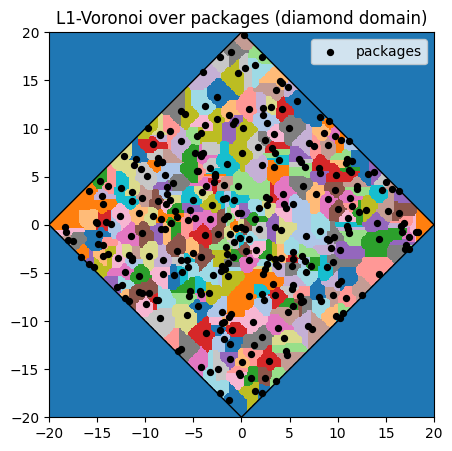

In [5]:
def plot_l1_voronoi_for_env(env: CoModalEnv, res: int = 200, show_delivered: bool = True):
    """
    栅格近似绘制 L1-Voronoi（以 env.pkg_pos_all 为种子），并裁剪在菱形 |x|+|y|<=R 内。
    - res: 栅格分辨率（边长像素数）
    """
    R = env.R
    # 生成栅格
    xs = np.linspace(-R, R, res)
    ys = np.linspace(-R, R, res)
    XX, YY = np.meshgrid(xs, ys)
    mask = (np.abs(XX) + np.abs(YY) <= R)           # 菱形内的点
    Xflat = XX[mask]; Yflat = YY[mask]
    P = np.stack([Xflat, Yflat], axis=1)            # [M,2]

    # 对每个格点找最近的种子（L1）
    seeds = env.pkg_pos_all                         # [N,2]
    # 直接 O(MN) 足够；如 N 大可考虑 KDTree(metric='manhattan')
    owner = np.argmin(np.abs(P[:,None,:] - seeds[None,:,:]).sum(axis=2), axis=1)  # [M]

    # 把 owner 回填到图像
    img = -np.ones_like(XX, dtype=int)
    img[mask] = owner

    # 画图
    plt.figure(figsize=(5,5))
    plt.imshow(img, origin="lower",
               extent=[-R, R, -R, R], interpolation="nearest", cmap="tab20")
    # 画边界菱形
    bx = np.array([-R, 0, R, 0, -R]); by = np.array([0, R, 0, -R, 0])
    plt.plot(bx, by, "k-", lw=1.0)
    # 画种子点
    plt.scatter(seeds[:,0], seeds[:,1], s=18, c="k", marker="o", label="packages")
    if show_delivered and hasattr(env, "pkg_delivered"):
        dmask = env.pkg_delivered
        if dmask.any():
            plt.scatter(seeds[dmask,0], seeds[dmask,1], s=30, facecolors="none", edgecolors="w", linewidths=1.5, label="delivered")
    plt.title("L1-Voronoi over packages (diamond domain)")
    plt.xlim([-R, R]); plt.ylim([-R, R]); plt.gca().set_aspect("equal", adjustable="box")
    plt.legend(loc="upper right")
    plt.show()


tmp = CoModalEnv()       # 用当前全局参数生成一个 episode
plot_l1_voronoi_for_env(tmp, res=300)


In [6]:

# =================
# Baseline policies
# =================
def run_episode(env: CoModalEnv, policy=None, greedy=False) -> Tuple[float, float, float, str, int]:
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    for _ in range(STEPS_PER_EP):
        if policy is None:
            # default: deliver-only baseline
            action = 0
        else:
            with torch.no_grad():
                o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                logits, _ = policy(o)
                # mask invalid
                invalid = (m < 0.5)
                logits = logits.masked_fill(invalid, -1e9)
                if greedy:
                    action = int(torch.argmax(logits, dim=-1).item())
                else:
                    probs = torch.softmax(logits, dim=-1)
                    action = int(torch.multinomial(probs, 1).item())
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break
    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    
    return total, terminal_time, revenue_rate, ended_reason, acc


def baseline_nearby_rule(env: CoModalEnv,
                         pickup_alpha=R_PICK_ALPHA,
                         drop_bias=0.5,
                         switch_grace_steps: Optional[int] = None
                         ) -> Tuple[float, float, float, str, int]:
   
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0

    grace_left = 0

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0  # Default: go to the nearest package
        
        gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)
        
        #Pre-grace
        # If the nearest package can be delivered in the next step, open the window in advance
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)
                

        if grace_left > 0:
            # Inside the window: as long as there is a qualified order, accept the one with the nearest pickup
            if len(visible) > 0:
                # Accept the one with the nearest pickup
                pk_d_list = [manhattan(env.pos, r.pickup) for r in visible]
                if HEUR_SOFT_PICK_CAP and min(pk_d_list) <= HEUR_SOFT_PICK_CAP:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
                    
                else:
                    action = 1 + int(np.argmin(pk_d_list))
                    grace_left = 0
            else:
                # If there are no qualified orders in the window, decrement the window counter
                grace_left -= 1

        # Execute action
        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_this_step", 0))
        if delivered_cnt > 0:
            # After delivering the package: open a new window (including the current and subsequent SWITCH_GRACE_STEPS steps)
            grace_left = max(1, gs)


        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc


def baseline_nearby_rule_voronoi(env: CoModalEnv,
                                 pickup_alpha=R_PICK_ALPHA,
                                 drop_bias=0.5,
                                 switch_grace_steps: Optional[int] = None
                                 ) -> Tuple[float, float, float, str, int]:
    """
    Switching policy (N=n) + L1-Voronoi dropoff filter:
      - 只在“刚送完一个包裹”后的若干步窗口内考虑接单；
      - 候选乘客先过滤：dropoff 必须不落在【已送达包裹】的 L1-Voronoi 细胞；
      - 若过滤后仍有候选，则接 pickup 最近的一单；否则继续送最近包裹。
    返回: (total_reward, terminal_time_min, revenue_rate, ended_reason, accepted_rides)
    """
    obs, mask = env.reset()
    total = 0.0
    terminal_time = None
    ended_reason = "unknown"
    acc = 0
    grace_left = 0

    gs = SWITCH_GRACE_STEPS if switch_grace_steps is None else int(switch_grace_steps)

    for _ in range(STEPS_PER_EP):
        visible = env._visible_rides()
        action = 0

        # 若下一步就能把最近包裹送达，则提前开启窗口
        nn = env._nearest_package()
        if nn is not None:
            dist_to_nn = manhattan(env.pos, nn)
            if grace_left == 0 and dist_to_nn <= (env.v * env.dt):
                grace_left = max(1, gs)

        if grace_left > 0:
            # 先用 Voronoi 规则过滤掉“drop 会落在已送达细胞内”的单
            cand = [r for r in visible if env.dropoff_allowed(r.dropoff)]
            if len(cand) > 0:
                # 接 pickup 最近的一单
                pk_d_list = [manhattan(env.pos, r.pickup) for r in cand]
                action = 1 + int(np.argmin(pk_d_list))
                grace_left = 0
            else:
                grace_left -= 1

        obs, r, done, info, mask = env.step(action)
        total += r

        delivered_cnt = int(info.get("delivered_step", 0))   # 注意：你的 env 用的是 "delivered_step"
        if delivered_cnt > 0:
            grace_left = max(1, gs)

        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = (total / terminal_time) if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc



In [7]:
# =================
# Four zone baseline policies relevant
# =================

# =========================
# Four-zone helpers (L1)
# =========================

def l1_zone_id(p: np.ndarray) -> int:
    """
    将菱形区域按 L1 准则等分为四区：
      zone 0: |x|>=|y| 且 x>=0  -> 右
      zone 1: |x|>=|y| 且 x<0   -> 左
      zone 2: |y|>|x| 且 y>=0   -> 上
      zone 3: |y|>|x| 且 y<0    -> 下
    """
    x, y = float(p[0]), float(p[1])
    if abs(x) >= abs(y):
        return 0 if x >= 0 else 1
    else:
        return 2 if y >= 0 else 3


def _l1_distance(a: Tuple[float,float], b: Tuple[float,float]) -> int:
    # OR-Tools 需要整数矩阵；这里用放大 1000 的整数近似，或直接四舍五入
    return int(round(abs(a[0]-b[0]) + abs(a[1]-b[1])))


def _build_distance_matrix_L1(pts: List[Tuple[float,float]]) -> List[List[int]]:
    n = len(pts)
    mat = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(n):
            if i != j:
                mat[i][j] = _l1_distance(pts[i], pts[j])
    return mat


def solve_zone_tsp_L1(points_xy: List[Tuple[float,float]],
                      start_xy: Tuple[float,float]) -> List[int]:
    """
    给定区内包裹点（points_xy）与当前起点（start_xy），
    用 OR-Tools 求解近似 TSP 访问顺序，返回访问 points_xy 的索引序列。
    - 我们构造虚拟的 depot = start_xy，与所有点连边；
    - 目标是从 depot 出发访问所有点（结束点任意）。
    """
    if not points_xy:
        return []

    # 构造节点列表：node 0 = depot（起点），1..n = 包裹点
    all_points = [start_xy] + list(points_xy)
    dist = _build_distance_matrix_L1(all_points)

    n_nodes = len(all_points)
    manager = pywrapcp.RoutingIndexManager(n_nodes, 1, 0)   # 单车，depot=0
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        i = manager.IndexToNode(from_index)
        j = manager.IndexToNode(to_index)
        return dist[i][j]

    transit_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_cb_idx)

    # 允许不回仓；默认就会求一条从 depot 出发的路径
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_params.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_params.time_limit.FromSeconds(2)  # 小规模足够

    solution = routing.SolveWithParameters(search_params)
    if solution is None:
        # 退化：若 OR-Tools 未给解，就按“从起点最近邻”排序
        order = sorted(range(len(points_xy)),
                       key=lambda k: abs(points_xy[k][0]-start_xy[0]) + abs(points_xy[k][1]-start_xy[1]))
        return order

    # 解析路径：节点编号 -> points 索引（减 1）
    idx = routing.Start(0)
    visit_order = []
    while not routing.IsEnd(idx):
        node = manager.IndexToNode(idx)
        if node != 0:  # 跳过 depot
            visit_order.append(node - 1)
        idx = solution.Value(routing.NextVar(idx))
    return visit_order

# =================
# Four zone baseline algorithm
# =================


def baseline_four_zone(env: CoModalEnv,
                       r_pick_alpha: float = R_PICK_ALPHA,
                       screen_window_min: float = 10.0
                       ) -> Tuple[float, float, float, str, int]:
    """
    Four-Zone Policy (FZ):
      1) 将所有包裹按 l1_zone_id 分到 4 个分区，逐区清空；
      2) 区内用 OR-Tools 求一个近似 TSP 访问顺序，严格按该序走；
      3) 在区内“末段”开启乘客筛选窗（持续 screen_window_min 分钟）：
           只考虑 pickup 在 r_pick 内且 TTL 合法、且 dropoff 属于“尚未服务区”的可见单；
         但 **直到清完本区** 才真正接单（如仍可见）；没单就直接去下一个未清区；
      4) 完成 ride 后，落在的区若未服务，则将它作为下一个服务区。
    输出与其它 baseline 保持一致：(reward, terminal_time, rate, ended_reason, accepted)
    """
    obs, mask = env.reset()
    total, terminal_time = 0.0, None
    ended_reason = "unknown"
    acc = 0

    # 预取常量
    r_pick = r_pick_alpha * env.R / math.sqrt(2.0)
    screen_steps = max(1, int(round(screen_window_min / env.dt)))

    # 初始分区：根据 reset 时的包裹
    def packages_by_zone():
        zones = {0: [], 1: [], 2: [], 3: []}
        for p in env.packages:
            zones[l1_zone_id(p)].append((float(p[0]), float(p[1])))
        return zones

    zones = packages_by_zone()

    def zone_has_pkg(zid: int) -> bool:
        return len(zones[zid]) > 0

    def pick_next_zone(cur_pos: np.ndarray) -> Optional[int]:
        # 选择“尚未清空且最近的区”（以到该区最近包裹点的 L1 距离度量）
        best, best_d = None, 1e18
        for zid in range(4):
            if not zone_has_pkg(zid):
                continue
            d_min = min(abs(px-cur_pos[0]) + abs(py-cur_pos[1]) for (px,py) in zones[zid])
            if d_min < best_d:
                best, best_d = zid, d_min
        return best

    # 规划某区的 TSP 顺序（基于当前 env.pos）
    def plan_zone_route(zid: int) -> List[Tuple[float,float]]:
        pts = zones[zid]
        order = solve_zone_tsp_L1(pts, (float(env.pos[0]), float(env.pos[1])))
        return [pts[k] for k in order]

    # 过滤可接受乘客（符合 r_pick/TTL 且 dropoff 在未服务区）
    def screened_visible_in_unserved():
        cand = []
        visible = env._visible_rides()
        unserved_zids = {z for z in range(4) if zone_has_pkg(z)}
        for r in visible:
            zid = l1_zone_id(r.dropoff)
            if zid in unserved_zids:
                # pickup 距离再验一次（env._visible_rides 已做 TTL+半径筛）
                if manhattan(env.pos, r.pickup) <= r_pick:
                    cand.append(r)
        # 选 pickup 最近的
        cand.sort(key=lambda rr: manhattan(env.pos, rr.pickup))
        return cand

    current_zone = pick_next_zone(env.pos)
    route = plan_zone_route(current_zone) if current_zone is not None else []

    # 路线指针 & 筛选窗计数器
    idx_in_route = 0
    screen_left = 0
    have_candidate = False   # 标记“有合格 ride 可接”，但要等清完本区才真正接

    for _ in range(STEPS_PER_EP):
        action = 0  # 默认送包裹
        # 若无当前区，尝试选一个
        if current_zone is None:
            current_zone = pick_next_zone(env.pos)
            if current_zone is not None:
                route = plan_zone_route(current_zone)
                idx_in_route = 0

        # 如果还有区内目标点，就朝下一个点走
        if current_zone is not None and idx_in_route < len(route):
            target = np.array(route[idx_in_route], dtype=np.float32)
            # 如果下一步可达（将到达该点），在“末段”开启筛选窗
            dist_to_target = manhattan(env.pos, target)
            if screen_left == 0 and dist_to_target <= (env.v * env.dt):
                screen_left = screen_steps

        # 筛选窗内：只筛，不接（直到该区清完）
        if screen_left > 0:
            screen_left -= 1
            cand = screened_visible_in_unserved()
            have_candidate = have_candidate or (len(cand) > 0)

        # 选择动作
        if env.to_pickup is not None or env.with_passenger:
            # 正在接/送客，action 无效
            pass
        else:
            # 如果当前区已清空（运行时判定以 env.packages 为准），允许尝试接单
            # 我们认为“本区清空”的判据：zones[current_zone] ∩ env.packages == ∅
            if current_zone is not None:
                # 同步 zones：把已送达的包裹从 zones 中删掉（通过坐标匹配）
                # 注意：env._deliver_if_arrived() 只在到达点时触发，这里用近似匹配
                alive = set((float(p[0]), float(p[1])) for p in env.packages)
                zones[current_zone] = [pt for pt in zones[current_zone] if pt in alive]

                if len(zones[current_zone]) == 0:
                    # 本区清空：若有合格候选且仍可见，则此刻接单（否则转去下一未清区）
                    if have_candidate:
                        visible = env._visible_rides()
                        # 依 pickup 最近且 drop 在未服务区的规则挑一个
                        best_idx, best_d = -1, 1e18
                        for i, r in enumerate(visible):
                            if l1_zone_id(r.dropoff) in {z for z in range(4) if zone_has_pkg(z)}:
                                d = manhattan(env.pos, r.pickup)
                                if d < best_d:
                                    best_d, best_idx = d, i
                        if best_idx >= 0:
                            action = 1 + best_idx
                            have_candidate = False
                    # 若没接到合格单，则跳到下一未清区并重新规划
                    if action == 0:
                        current_zone = pick_next_zone(env.pos)
                        if current_zone is not None:
                            route = plan_zone_route(current_zone)
                            idx_in_route = 0

            # 没在接客、也没触发接单，就继续按 route 送包裹
            # （基于 env.step 内部“到点才投递”的机制，只需 action=0）
            pass

        # 执行动作
        obs, r, done, info, mask = env.step(action)
        total += r
        if done:
            terminal_time = float(info.get("terminal_time_min", env.t))
            ended_reason  = str(info.get("ended_reason", env._ended_reason or "unknown"))
            acc = int(info.get("accepted_rides", getattr(env, "accepted_rides", 0)))
            break

        # 若刚投递成功，则前进 route 指针（利用 delivered_step 标志）
        delivered_cnt = int(info.get("delivered_step", 0))
        if delivered_cnt > 0 and current_zone is not None and idx_in_route < len(route):
            # 如果当前位置等于 route[idx]，向前推进
            cur = (float(env.pos[0]), float(env.pos[1]))
            if idx_in_route < len(route) and cur == route[idx_in_route]:
                idx_in_route += 1

    if terminal_time is None:
        terminal_time = float(env.t)
    revenue_rate = total / terminal_time if terminal_time > 0 else 0.0
    return total, terminal_time, revenue_rate, ended_reason, acc



In [8]:

# ==============
# PPO Components
# ==============
class ActorCritic(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int):
        super().__init__()
        hid = 256
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hid, hid), 
            nn.LayerNorm(hid),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        self.pi = nn.Linear(hid, act_dim)
        self.v  = nn.Linear(hid, 1)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.net(x)
        return self.pi(h), self.v(h)


def ppo_update(policy: ActorCritic, optimizer, batch, clip_eps=CLIP_EPS):
    obs, act, old_logp, ret, adv, mask = batch
    logits, v = policy(obs)
    # mask invalid actions
    invalid = (mask < 0.5)
    logits = logits.masked_fill(invalid, -1e9)
    dist = torch.distributions.Categorical(logits=logits)
    logp = dist.log_prob(act)
    ratio = torch.exp(logp - old_logp)

    clip_adv = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv
    pi_loss = -(torch.min(ratio * adv, clip_adv)).mean()
    v_loss = ((ret - v.squeeze(-1)) ** 2).mean()

    ent = dist.entropy().mean()
    loss = pi_loss + VF_COEF * v_loss - ENT_COEF * ent

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
    optimizer.step()

    return pi_loss.item(), v_loss.item(), ent.item(), loss.item()


def collect_rollout(env: CoModalEnv, policy: ActorCritic, steps: int):
    # buffers
    obs_buf, act_buf, rew_buf, val_buf, next_val_buf, logp_buf, mask_buf, done_buf = [], [], [], [], [], [], [], []

    obs, mask = env.reset()
    for _ in range(steps):
        o = torch.tensor(obs, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        m = torch.tensor(mask, dtype=torch.float32, device=DEVICE).unsqueeze(0)
        with torch.no_grad():
            logits, v = policy(o)
            invalid = (m < 0.5)
            logits = logits.masked_fill(invalid, -1e9)
            dist = torch.distributions.Categorical(logits=logits)
            a = dist.sample()
            logp = dist.log_prob(a).squeeze(0)
            v_cur = v.squeeze(0).squeeze(-1)             # V(s_t)

        # step env
        obs2, r, done, _, mask2 = env.step(int(a.item()))

        # compute V(s_{t+1}) for GAE bootstrap
        with torch.no_grad():
            o2 = torch.tensor(obs2, dtype=torch.float32, device=DEVICE).unsqueeze(0)
            _, v_next = policy(o2)
            v_next = v_next.squeeze(0).squeeze(-1)       # V(s_{t+1})

        # store
        obs_buf.append(o.squeeze(0).cpu().numpy())
        mask_buf.append(m.squeeze(0).cpu().numpy())
        act_buf.append(a.cpu().numpy())
        rew_buf.append(r)
        val_buf.append(v_cur.cpu().numpy())
        next_val_buf.append(v_next.cpu().numpy())
        logp_buf.append(logp.cpu().numpy())
        done_buf.append(done)

        obs, mask = obs2, mask2
        if done:
            obs, mask = env.reset()

    # ---------- GAE(λ) advantages & returns ----------
    # arrays
    rewards = np.array(rew_buf, dtype=np.float32)
    values  = np.array(val_buf, dtype=np.float32)
    next_values = np.array(next_val_buf, dtype=np.float32)
    dones   = np.array(done_buf, dtype=np.float32)  # 1.0 if done else 0.0

    advantages = np.zeros_like(rewards, dtype=np.float32)
    gae = 0.0
    gamma = DISCOUNT
    lam = GAE_LAMBDA

    # backward recursion
    for t in reversed(range(len(rewards))):
        nonterminal = 1.0 - dones[t]
        delta = rewards[t] + gamma * next_values[t] * nonterminal - values[t]
        gae = delta + gamma * lam * nonterminal * gae
        advantages[t] = gae

    returns = advantages + values  # target for value head

    # tensors
    obs_t  = torch.tensor(np.array(obs_buf), dtype=torch.float32, device=DEVICE)
    act_t  = torch.tensor(np.array(act_buf).squeeze(-1), dtype=torch.long, device=DEVICE)
    ret_t  = torch.tensor(returns, dtype=torch.float32, device=DEVICE)
    adv_t  = torch.tensor(advantages, dtype=torch.float32, device=DEVICE)
    logp_t = torch.tensor(np.array(logp_buf), dtype=torch.float32, device=DEVICE)
    mask_t = torch.tensor(np.array(mask_buf), dtype=torch.float32, device=DEVICE)

    # normalize advantages (keep returns unnormalized)
    adv_t = (adv_t - adv_t.mean()) / (adv_t.std() + 1e-8)

    return obs_t, act_t, logp_t, ret_t, adv_t, mask_t



def make_minibatches(batch, batch_size):
    N = batch[0].shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    for i in range(0, N, batch_size):
        j = idx[i:i+batch_size]
        yield tuple(x[j] for x in batch)


In [9]:
def evaluate_all(env: CoModalEnv, policy: ActorCritic, heur_grace_steps: Optional[int] = None):
    prev_mode = policy.training
    policy.eval()
    try:
        drl_eps   = [run_episode(env, policy, greedy=True)        for _ in range(EVAL_EPISODES)]
        pure_eps  = [run_episode(env, policy=None)                for _ in range(EVAL_EPISODES)]
        heur_eps  = [baseline_nearby_rule(env, heur_grace_steps)  for _ in range(EVAL_EPISODES)]
        hv_eps    = [baseline_nearby_rule_voronoi(env, heur_grace_steps) for _ in range(EVAL_EPISODES)]
        fz_eps    = [baseline_four_zone(env) for _ in range(EVAL_EPISODES)]

        def _descale_eps(eps):
            if not REPORT_UNSCALED:
                return eps
            fixed = []
            for e in eps:
                if len(e) == 5:
                    R, T, Rate, reason, acc = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason, acc))
                else:
                    R, T, Rate, reason = e
                    fixed.append((R * INV_REWARD_SCALE, T, Rate * INV_REWARD_SCALE, reason))
            return fixed

        drl_out = _descale_eps(drl_eps)
        pure_out= _descale_eps(pure_eps)
        heur_out= _descale_eps(heur_eps)
        hv_out  = _descale_eps(hv_eps)
        fz_out  = _descale_eps(fz_eps)

        def agg(eps):
            R  = np.array([e[0] for e in eps], dtype=float)
            T  = np.array([e[1] for e in eps], dtype=float)
            Rt = np.array([e[2] for e in eps], dtype=float)
            out = dict(avg_reward=R.mean(), avg_t=T.mean(), avg_rate=Rt.mean())
            if len(eps[0]) == 5:
                A = np.array([e[4] for e in eps], dtype=float)
                out["avg_acc"] = A.mean()
            return out

        def pprint(name, eps):
            print(f"  {name} episodes:")
            if len(eps[0]) == 5:
                for i, (R, T, rate, reason, acc) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, accepted={acc:3d}, reason={reason}{mark}")
            else:
                for i, (R, T, rate, reason) in enumerate(eps):
                    mark = " (early-packages-done)" if reason == "packages_done" else ""
                    print(f"    Ep{i+1:02d}: reward={R:8.2f}, terminal_time={T:7.2f} min, rate={rate:6.3f}/min, reason={reason}{mark}")

        pprint("DRL ", drl_out)
        pprint("HEUR", heur_out)
        pprint("HVOR", hv_out)
        pprint("FZ", fz_out)
        pprint("PURE", pure_out)
        
        return {
            "drl": agg(drl_out),
            "heur": agg(heur_out),
            "heur_vor": agg(hv_out),
            "four_zone": agg(fz_out),
            "pure": agg(pure_out)
        }
    finally:
        if prev_mode:
            policy.train()


In [10]:

def main():
    env = CoModalEnv()
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    policy.train()
    optimizer = optim.Adam(policy.parameters(), lr=LR)

    print(f"Device: {DEVICE}, obs_dim={env.obs_dim}, act_dim={env.act_dim}")
    print("Start training PPO...")
    for upd in range(1, UPDATES + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)
        if upd % 5 == 0:
            metrics = evaluate_all(env, policy)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]
            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, Rate={heur['avg_rate']:6.3f}/m | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, Rate={hv['avg_rate']:6.3f}/m | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, Rate={fz['avg_rate']:6.3f}/m | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, Rate={pure['avg_rate']:6.3f}/m "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")


    # Final evaluation
    metrics = evaluate_all(env, policy)
    drl  = metrics["drl"]
    heur = metrics["heur"]
    hv   = metrics["heur_vor"]
    fz   = metrics["four_zone"]
    pure = metrics["pure"]

    print("="*80)
    print(f"Final evaluation over {EVAL_EPISODES} eps (<= {HORIZON_MIN:.0f} min each):")
    print(f"  DRL (greedy):        R={drl['avg_reward']:.2f}, T={drl['avg_t']:.2f}m, Rate={drl['avg_rate']:.3f}/m, Acc={drl.get('avg_acc', float('nan')):.2f}")
    print(f"  Nearby heuristic:    R={heur['avg_reward']:.2f}, T={heur['avg_t']:.2f}m, Rate={heur['avg_rate']:.3f}/m")
    print(f"  Heur. + Voronoi:     R={hv['avg_reward']:.2f}, T={hv['avg_t']:.2f}m, Rate={hv['avg_rate']:.3f}/m")
    print(f"  Four-Zone heuristic: R={fz['avg_reward']:.2f}, T={fz['avg_t']:.2f}m, Rate={fz['avg_rate']:.3f}/m")
    print(f"  Pure delivery only:  R={pure['avg_reward']:.2f}, T={pure['avg_t']:.2f}m, Rate={pure['avg_rate']:.3f}/m")



In [11]:
"""
if __name__ == "__main__":
    main()
"""

'\nif __name__ == "__main__":\n    main()\n'

In [12]:
# =========================
# Grid runner & CSV logger
# =========================

def train_policy_brief(env: CoModalEnv,
                       updates: int,
                       *,
                       eval_every: int = 10,
                       heur_grace_steps: Optional[int] = None):
    """
    Trainer: every `eval_every` updates call evaluate_all (same style as main()) and print logs.
    Returns (policy, last_metrics).
    """
    policy = ActorCritic(env.obs_dim, env.act_dim).to(DEVICE)
    optimizer = optim.Adam(policy.parameters(), lr=LR)
    policy.train()

    last_metrics = None
    pi_l = v_l = ent = 0.0  # just for printing

    if updates <= 0:
        # No training, just one evaluation as "last_metrics"
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
        return policy, last_metrics

    for upd in range(1, updates + 1):
        batch = collect_rollout(env, policy, PPO_STEPS)
        for _ in range(PPO_EPOCHS):
            for mb in make_minibatches(batch, PPO_MINI_BATCH):
                pi_l, v_l, ent, tot = ppo_update(policy, optimizer, mb, CLIP_EPS)

        # ---- same cadence as main(): evaluate and print every `eval_every` ----
        if eval_every and (upd % eval_every == 0):
            metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
            drl  = metrics["drl"]
            heur = metrics["heur"]
            hv   = metrics["heur_vor"]
            fz   = metrics["four_zone"]
            pure = metrics["pure"]

            # align print format to main() + include HVOR

            print(f"[Upd {upd:03d}] "
                f"DRL:  R={drl['avg_reward']:8.2f}, T={drl['avg_t']:7.2f}m, "
                f"Rate={drl['avg_rate']:6.3f}/m, Acc={drl.get('avg_acc', float('nan')):5.2f} | "
                f"HEUR: R={heur['avg_reward']:8.2f}, T={heur['avg_t']:7.2f}m, "
                f"Rate={heur['avg_rate']:6.3f}/m | "
                f"HVOR: R={hv['avg_reward']:8.2f}, T={hv['avg_t']:7.2f}m, "
                f"Rate={hv['avg_rate']:6.3f}/m | "
                f"FZON: R={fz['avg_reward']:8.2f}, T={fz['avg_t']:7.2f}m, "
                f"Rate={fz['avg_rate']:6.3f}/m | "
                f"PURE: R={pure['avg_reward']:8.2f}, T={pure['avg_t']:7.2f}m, "
                f"Rate={pure['avg_rate']:6.3f}/m "
                f"|| pi={pi_l:.3f} v={v_l:.3f} ent={ent:.3f}")
            last_metrics = metrics

    # final evaluation block (mirrors main())
    if last_metrics is None:
        last_metrics = evaluate_all(env, policy, heur_grace_steps=heur_grace_steps)
    return policy, last_metrics




def run_param_sweep(
    LAMBDA_list,
    R_PICK_ALPHA_list,
    GAMMA_PACK_list,
    RIDE_TTL_MINUTES_list,
    MAX_VISIBLE_RIDES_list,
    SWITCH_GRACE_STEPS_list,
    *,
    train_updates_per_combo: int = 0,      # Set to 200 for same training intensity as main()
    csv_path: str = "param_sweep_results.csv",
    seed_offset: int = 0                   # Optional: offset seed for parallel/multiple runs
):
    rows = []
    combo_id = 0

    for Lam, Alpha, Gamm, TTL, MV, SGS in itertools.product(
        LAMBDA_list, R_PICK_ALPHA_list, GAMMA_PACK_list,
        RIDE_TTL_MINUTES_list, MAX_VISIBLE_RIDES_list, SWITCH_GRACE_STEPS_list
    ):
        combo_id += 1

        # --- Set a separate seed for each combination to ensure reproducibility and training progress similar to main() --- #
        set_global_seeds(SEED + seed_offset + combo_id) 

        # Construct the environment for this combination (use global for R/V/DT/HORIZON etc.; if you want to sweep them, pass them in)
        env = CoModalEnv(lam=Lam,
                         gamma_pack=Gamm,
                         r_pick_alpha=Alpha,
                         ride_ttl_minutes=TTL,
                         max_visible=MV)

        # Train (including "evaluate and print every 5 updates"), return policy and the last metrics
        policy, metrics = train_policy_brief(env,
                                             updates=train_updates_per_combo,
                                             eval_every=5,
                                             heur_grace_steps=SGS)

        # Write CSV: take the last metrics (presentation-layer unscaled)
        for algo_key in ["drl", "heur", "heur_vor", "four_zone", "pure"]:
            m = metrics[algo_key]
            rows.append({
                "combo_id": combo_id,
                "algo": algo_key.upper(),
                "LAMBDA": Lam,
                "R_PICK_ALPHA": Alpha,
                "GAMMA_PACK": Gamm,
                "RIDE_TTL_MIN": TTL,
                "MAX_VISIBLE_RIDES": MV,
                "SWITCH_GRACE_STEPS": SGS,
                "reward": float(m["avg_reward"]),
                "rate":   float(m["avg_rate"]),
                "terminal_time": float(m["avg_t"]),
                "accepted": float(m.get("avg_acc", float('nan')))
            })


    df = pd.DataFrame(rows)
    df.to_csv(csv_path, index=False)
    print(f"[GRID] Wrote {len(df)} rows to {csv_path}")
    return df


In [13]:
# ==============
# Plot utilities
# ==============
def plot_single_param_trend(df: pd.DataFrame, vary_key: str, metric: str = "rate",
                            algos=("DRL", "HEUR", "HEUR_VOR", "FOUR_ZONE", "PURE"),
                            savepath: Optional[str] = None):
    """
    Plot the trend line of a metric for a single parameter vary_key (other parameters are automatically aggregated by mean).
    """
    # Keep only necessary columns
    cols = ["algo", vary_key, metric]
    tmp = df[cols].dropna()
    # Aggregate: take the mean for the same algo & vary_key
    pivot = (tmp.groupby(["algo", vary_key])[metric]
                .mean()
                .reset_index()
                .pivot(index=vary_key, columns="algo", values=metric)
                .sort_index())
    plt.figure()
    for algo in algos:
        if algo in pivot.columns:
            plt.plot(pivot.index.values, pivot[algo].values, marker="o", label=algo)
    plt.xlabel(vary_key)
    plt.ylabel(metric)
    plt.title(f"{metric} vs {vary_key}")
    plt.legend()
    if savepath:
        plt.savefig(savepath, bbox_inches="tight", dpi=150)
    plt.show()


def plot_from_csv(csv_path: str, vary_keys, metrics=("rate", "reward", "accepted")):
    df = pd.read_csv(csv_path)
    for k in vary_keys:
        for m in metrics:
            out = f"plot_{m}_vs_{k}.png"
            plot_single_param_trend(df, k, m, savepath=out)
            print(f"[PLOT] Saved {out}")


  DRL  episodes:
    Ep01: reward=  442.16, terminal_time= 550.00 min, rate= 0.804/min, accepted=  1, reason=packages_done (early-packages-done)
    Ep02: reward=  709.48, terminal_time= 593.50 min, rate= 1.195/min, accepted=  3, reason=packages_done (early-packages-done)
    Ep03: reward=  988.42, terminal_time= 655.00 min, rate= 1.509/min, accepted=  4, reason=packages_done (early-packages-done)
    Ep04: reward=  542.46, terminal_time= 568.50 min, rate= 0.954/min, accepted=  3, reason=packages_done (early-packages-done)
    Ep05: reward= 1134.38, terminal_time= 696.50 min, rate= 1.629/min, accepted=  4, reason=packages_done (early-packages-done)
  HEUR episodes:
    Ep01: reward=  197.00, terminal_time= 494.50 min, rate= 0.398/min, accepted=  0, reason=packages_done (early-packages-done)
    Ep02: reward=  467.98, terminal_time= 605.00 min, rate= 0.774/min, accepted=  1, reason=packages_done (early-packages-done)
    Ep03: reward=  406.29, terminal_time= 555.50 min, rate= 0.731/min,

,combo_id,algo,LAMBDA,R_PICK_ALPHA,GAMMA_PACK,RIDE_TTL_MIN,MAX_VISIBLE_RIDES,SWITCH_GRACE_STEPS,reward,rate,terminal_time,accepted
0,1,DRL,0.4,0.6,0.5,3,5,6,669.370224,1.146587,561.8,3.6
1,1,HEUR,0.4,0.6,0.5,3,5,6,460.555804,0.780551,560.7,1.6
2,1,HEUR_VOR,0.4,0.6,0.5,3,5,6,374.044684,0.680097,541.0,1.0
3,1,FOUR_ZONE,0.4,0.6,0.5,3,5,6,215.000000,0.394518,545.2,0.0
4,1,PURE,0.4,0.6,0.5,3,5,6,203.800000,0.385733,531.9,0.0
5,2,DRL,0.4,0.6,0.5,5,5,6,1432.710413,1.933419,728.5,8.2
6,2,HEUR,0.4,0.6,0.5,5,5,6,1275.879260,1.765558,706.8,7.0
7,2,HEUR_VOR,0.4,0.6,0.5,5,5,6,995.168274,1.562801,631.4,4.6
8,2,FOUR_ZONE,0.4,0.6,0.5,5,5,6,198.200000,0.397549,498.3,0.0
9,2,PURE,0.4,0.6,0.5,5,5,6,209.400000,0.398353,525.6,0.0


Saved to param_sweep_results_2.csv


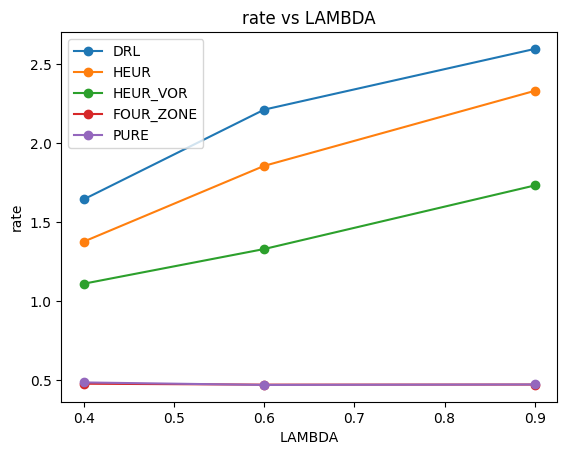

[PLOT] Saved plot_rate_vs_LAMBDA.png


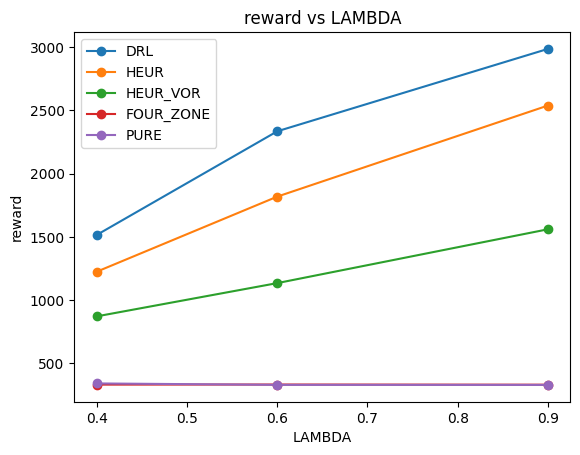

[PLOT] Saved plot_reward_vs_LAMBDA.png


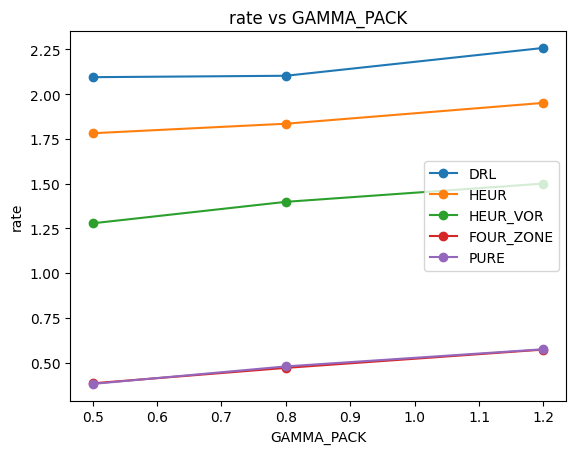

[PLOT] Saved plot_rate_vs_GAMMA_PACK.png


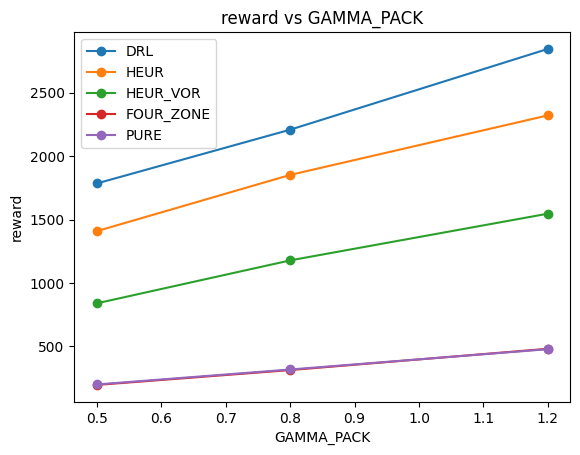

[PLOT] Saved plot_reward_vs_GAMMA_PACK.png


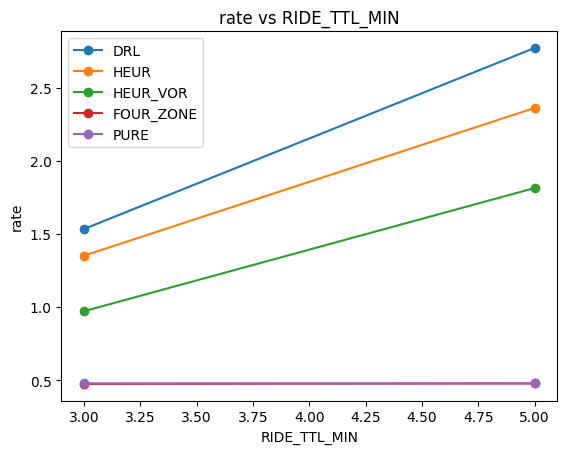

[PLOT] Saved plot_rate_vs_RIDE_TTL_MIN.png


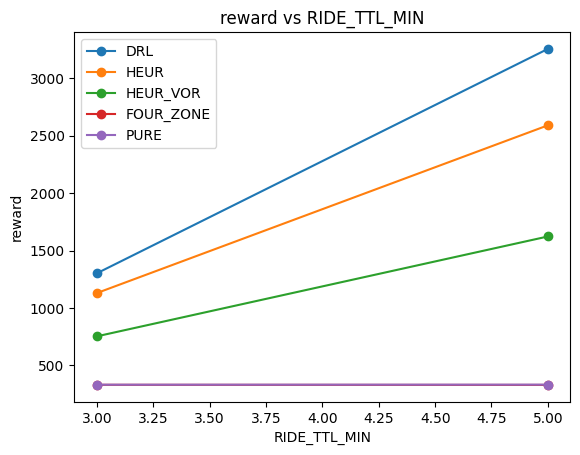

[PLOT] Saved plot_reward_vs_RIDE_TTL_MIN.png


In [14]:
LAMBDA_list            = [0.4, 0.6, 0.9]
R_PICK_ALPHA_list      = [0.6]
GAMMA_PACK_list        = [0.5, 0.8, 1.2]
RIDE_TTL_MINUTES_list  = [3, 5]
MAX_VISIBLE_RIDES_list = [5]
SWITCH_GRACE_STEPS_list= [6]

CSV_PATH = "param_sweep_results_2.csv"

df = run_param_sweep(LAMBDA_list,
                     R_PICK_ALPHA_list,
                     GAMMA_PACK_list,
                     RIDE_TTL_MINUTES_list,
                     MAX_VISIBLE_RIDES_list,
                     SWITCH_GRACE_STEPS_list,
                     train_updates_per_combo=20,      # Set to 20~50 for short DRL training. Set to 200 for full training of each parameter combination.
                     csv_path=CSV_PATH,
                     seed_offset=0)

display(df.head(12))
print(f"Saved to {CSV_PATH}")

# Plot single-parameter trend graphs (will be saved as PNG)
plot_from_csv(CSV_PATH,
              vary_keys=["LAMBDA","GAMMA_PACK",
                         "RIDE_TTL_MIN"],
              metrics=("rate", "reward", "accepted"))
